# <font color = red> Check the following for a more modular way to run on GPU </font>

**Education/MOOC/DL_PyTorch/MyNotes/03_MNIST_usingANN.ipynb**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader  # lets us load data in batches

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
# Reading data 
df = pd.read_csv("../../SMU_DS7331_Promotions_final/data/data_for_classification.csv")

## 1. Data Cleanup

**This is the same preprocesing that was done in Lab2 for SMU - DS7331 (Machine Learning 1 class). Please refer to that notebook for detailed explanation of what is being done.**

### 1.1 Remove Null Values

In [3]:
null_vals = df.isnull().sum(axis = 0)
print(null_vals[null_vals != 0])
df.dropna(inplace=True)

reporting_level_last                 14
accountability_matrix_label_last      3
functional_area_last                  3
job_family_label_last                 5
job_long_text_last                    6
operational_rollup_label_last       191
org_unit_desc_last                   44
dtype: int64


### 1.2 Remvove categorical variables with large number of levels 
**May reconsider later if using enbeddings in the NN**

In [4]:
categorical_features = df.select_dtypes(include='object').columns
categorical_features

Index(['worker', 'accountability_matrix_label_last', 'company_code_last',
       'cost_center_code_last', 'functional_area_last', 'supervisor_last',
       'gjs_code_label_last', 'gjs_framework_last', 'job_family_label_last',
       'job_long_text_last', 'operational_rollup_label_last',
       'org_unit_desc_last', 'site_city_code_last', 'site_country_code_last',
       'site_country_region_last', 'site_country_segment_last',
       'site_desc_last', 'certificate_order_grp_last'],
      dtype='object')

In [5]:
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'worker': 66927
The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'cost_center_code_last': 1943
The number of levels in column 'functional_area_last': 3
The number of levels in column 'supervisor_last': 9755
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'job_long_text_last': 1506
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'org_unit_desc_last': 8342
The number of levels in column 'site_city_code_last': 224
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'site_desc_last': 318
The 

In [6]:
cols_to_del = ["supervisor_last"
               ,"org_unit_desc_last"
               ,"cost_center_code_last"
               ,"job_long_text_last"
               ,"site_city_code_last"
               ,"site_desc_last"  
               ,"year_last"
               ,"month_num_last"
               ,'months_since_promotion_max'
               ,"worker"
               ,"Unnamed: 0"
                ]
for column in df.columns:
    if column in cols_to_del:
        del df[column]

In [7]:
categorical_features = df.select_dtypes(include='object').columns
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'functional_area_last': 3
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'certificate_order_grp_last': 14


In [8]:
#df.info()

## 2. Modeling

### 2.1 Separate continuous, categorical and label column names

In [9]:
categorical_features.values

array(['accountability_matrix_label_last', 'company_code_last',
       'functional_area_last', 'gjs_code_label_last',
       'gjs_framework_last', 'job_family_label_last',
       'operational_rollup_label_last', 'site_country_code_last',
       'site_country_region_last', 'site_country_segment_last',
       'certificate_order_grp_last'], dtype=object)

In [10]:
cat_cols = list(categorical_features.values)
y_col = ['promotion_max']  # this column contains the labels
cont_cols = [col for col in df.columns if col not in cat_cols + y_col]

# RUN THIS CODE TO COMPARE RESULTS:
print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

cat_cols  has 11 columns
cont_cols has 51 columns
y_col     has 1 column


### 2.2 Random Shuffle (Good Practice)

In [11]:
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)

### 2.3 Set the embedding sizes

In [12]:
# Converting categorical columns to category dtypes
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [13]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
print(emb_szs)

[(29, 15), (50, 25), (3, 2), (43, 22), (9, 5), (199, 50), (162, 50), (28, 14), (3, 2), (11, 6), (14, 7)]


### 2.4 Create Categorical and Continuous Tensors

In [14]:
#### Create an array of categorical values and convert to tensors
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int64) 

In [15]:
#### Create an array of continuous values and convert to tensors
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)

In [16]:
### Create a label tensor
y = torch.tensor(df[y_col].values).flatten()
y

tensor([0, 0, 0,  ..., 0, 0, 0])

### 2.5 Create Train Test Datasets

In [17]:
#### 9.0 Create train and test sets from cats, conts, and y
total_size = cats.shape[0]
test_size = int(cats.shape[0] * 0.2)  # 20% for test

print("Total Size: {}".format(total_size))
print("Train Size: {}".format(total_size-test_size))
print("Test Size: {}".format(test_size))



Total Size: 94108
Train Size: 75287
Test Size: 18821


In [18]:
cat_train = cats[:total_size-test_size].cuda()
cat_test = cats[total_size-test_size:total_size].cuda()
con_train = conts[:total_size-test_size].cuda()
con_test = conts[total_size-test_size:total_size].cuda()
y_train = y[:total_size-test_size].cuda()
y_test = y[total_size-test_size:total_size].cuda()

#### 2.5.1 Custom Dataset

In [19]:
class DatasetTabular(Dataset):
    
    def __init__(self, cats=None, conts=None, y=None, transform=None):
        """
        cats = Tensor for all categorical features
        consts = Tensor of all continuous features
        y = tensor of all labels
        """
        self.cats = cats
        self.conts = conts
        self.y = y
        self.transform = transform
        
    def __len__(self):
        if self.cats is not None:
            return len(self.cats)
        elif self.conts is not None:
            return len(self.conts)
                
    def __getitem__(self, index):
        cat = self.cats[index]
        cont = self.conts[index]
        label = self.y[index]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return cat, cont, label

In [20]:
train_data = DatasetTabular(cat_train, con_train, y_train)
test_data = DatasetTabular(cat_test, con_test, y_test)

#### 2.5.2 Data Loader

In [21]:
torch.manual_seed(101)  # for consistent results
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

### 2.6 Define the Tabular Model Class

In [22]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [23]:
torch.manual_seed(33)
model = TabularModel(emb_szs=emb_szs,
                     n_cont=conts.shape[1],
                     out_sz=2, # There are 2 class levels
                     layers=[200,100,50,10],
                     p=0.1) 

# NOTE: For this dataset, reducing probability of dropout might improve train and test accuracy further

model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(29, 15)
    (1): Embedding(50, 25)
    (2): Embedding(3, 2)
    (3): Embedding(43, 22)
    (4): Embedding(9, 5)
    (5): Embedding(199, 50)
    (6): Embedding(162, 50)
    (7): Embedding(28, 14)
    (8): Embedding(3, 2)
    (9): Embedding(11, 6)
    (10): Embedding(14, 7)
  )
  (emb_drop): Dropout(p=0.1)
  (bn_cont): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=249, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace)
    (10): BatchNorm1d(50, eps=1e-05, m

In [24]:
# Check availability
if torch.cuda.is_available():
    model = model.cuda()

next(model.parameters()).is_cuda # Need to send model to GPU as well.

True

### 2.7 Define the loss and optimization functions

In [25]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 2.8 Train the Model

In [26]:
# # Example 1 of how to use train loader
# for i_batch, sample_batched in enumerate(train_loader):
#     break
    
# print("Batch: {}".format(i_batch))
# print("Categorical Variables in batch:  {}".format(sample_batched[0].size())) # Categorical Variables
# print("Continuous in batch:             {}".format(sample_batched[1].size())) # Continuous Variables
# print("Dependent Variables in batch:    {}".format(sample_batched[2].size())) # Labels

In [27]:
# # Example 2 of how to use train loader
# for i_batch, (cat_train, con_train, y_train) in enumerate(train_loader):
#     break
    
# print("Batch: {}".format(i_batch))
# print("Categorical Variables in batch:  {}".format(cat_train.size())) # Categorical Variables
# print("Continuous in batch:             {}".format(con_train.size())) # Continuous Variables
# print("Dependent Variables in batch:    {}".format(y_train.size())) # Labels

In [28]:
import time
start_time = time.time()

epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    epoch_start_time = time.time()
    
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (cat_train, con_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(cat_train, con_train)  
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         # Print interim results
#         if b%200 == 0:
#             print(f'epoch: {i:2}  batch: {b:4} loss: {loss.item():10.8f}  \
# train accuracy: {trn_corr.item()*100/(train_loader.batch_size*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (cat_test, con_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(cat_test, con_test)  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    tst_loss = criterion(y_val, y_test)
    test_losses.append(tst_loss)
    test_correct.append(tst_corr)

    epoch_duration = time.time() - epoch_start_time 
    print(f'epoch: {(i+1):2} train_loss: {loss.item():7.5f} test_loss: {tst_loss.item():7.5f}  \
train_acc: {trn_corr.item()*100/(len(train_data)):5.1f}% \
test_acc: {tst_corr.item()*100/(len(test_data)):5.1f}% epoch_duration: {round(epoch_duration)}s')
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed     

epoch:  1 train_loss: 0.41585 test_loss: 0.44457  train_acc:  73.1% test_acc:  79.7% epoch_duration: 20s
epoch:  2 train_loss: 0.49578 test_loss: 0.42185  train_acc:  80.5% test_acc:  81.7% epoch_duration: 18s
epoch:  3 train_loss: 0.41309 test_loss: 0.39148  train_acc:  82.4% test_acc:  82.8% epoch_duration: 18s
epoch:  4 train_loss: 0.47382 test_loss: 0.33978  train_acc:  83.6% test_acc:  83.8% epoch_duration: 18s
epoch:  5 train_loss: 0.31501 test_loss: 0.38104  train_acc:  84.4% test_acc:  84.1% epoch_duration: 17s
epoch:  6 train_loss: 0.57996 test_loss: 0.35889  train_acc:  85.2% test_acc:  84.7% epoch_duration: 18s
epoch:  7 train_loss: 0.50833 test_loss: 0.31525  train_acc:  85.7% test_acc:  85.1% epoch_duration: 18s
epoch:  8 train_loss: 1.19142 test_loss: 0.36237  train_acc:  86.2% test_acc:  85.3% epoch_duration: 18s
epoch:  9 train_loss: 0.26956 test_loss: 0.36652  train_acc:  86.5% test_acc:  85.4% epoch_duration: 17s
epoch: 10 train_loss: 0.22365 test_loss: 0.35115  train

### 2.9 Visualize Training Progress

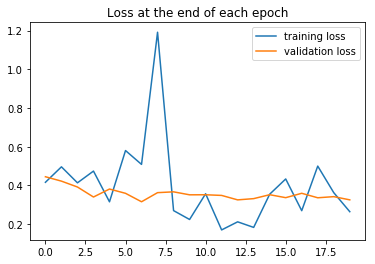

In [29]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

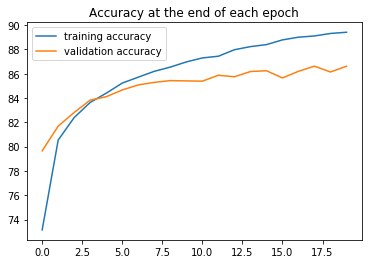

In [30]:
plt.plot([t.item()/train_loader.dataset.y.size()[0] * 100 for t in train_correct], label='training accuracy')
plt.plot([t.item()/test_loader.dataset.y.size()[0] * 100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### 2.10 Test Data Performance

In [31]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [32]:
with torch.no_grad():
    correct = 0
    for cat_test, con_test, y_test in test_load_all:
        y_val = model(cat_test, con_test)  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 16325/18821 =  86.738%


In [33]:
from sklearn.metrics import confusion_matrix
y_true = y_test.cpu().numpy()
y_pred = predicted.cpu().numpy()
confusion_matrix(y_true, y_pred)

array([[12293,  1143],
       [ 1353,  4032]], dtype=int64)

In [34]:
# Another way to print Confusion Matrix
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(2).reshape(1,-1))
print()

# print the confusion matrix
print(confusion_matrix(y_test.cpu().view(-1), predicted.cpu().view(-1)))

[[   0    1]]

[[12293 1143]
 [1353 4032]]


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     13436
           1       0.78      0.75      0.76      5385

   micro avg       0.87      0.87      0.87     18821
   macro avg       0.84      0.83      0.84     18821
weighted avg       0.87      0.87      0.87     18821

